# Introducing the Keras Sequential API on Vertex AI Platform

**Learning objectives**
  1. Build a DNN model using the Keras Sequential API
  1. Learn how to use feature columns in a Keras model
  1. Learn how to train a model with Keras
  1. Learn how to save/load, and deploy a Keras model on GCP
  1. Learn how to deploy the Model to Vertex AI and make predictions with the Keras model

## Introduction

The [Keras sequential API](https://keras.io/models/sequential/) allows you to create Tensorflow models layer-by-layer. This is useful for building most kinds of machine learning models but it does not allow you to create models that share layers, re-use layers or have multiple inputs or outputs. 

In this lab, we'll see how to build a simple deep neural network model using the Keras sequential api and feature columns. Once we have trained our model, we will deploy it using Vertex AI and see how to call our model for online prediciton.

Each learning objective will correspond to a __#TODO__ in the [student lab notebook](../labs/3_keras_sequential_api.ipynb) -- try to complete that notebook first before reviewing this solution notebook.


In [ ]:
!sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

In [1]:
!pip3 install google-cloud-bigquery==3.25.0 -U

     |████████████████████████████████| 239 kB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 412 kB 10.2 MB/s eta 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.27.2 which is incompatible.


In [2]:
!pip install google-cloud-aiplatform==1.59.0

     |████████████████████████████████| 5.1 MB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 394 kB 10.7 MB/s eta 0:00:01
  Using cached docstring_parser-0.16-py3-none-any.whl (36 kB)
     |████████████████████████████████| 339 kB 50.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.4 MB 59.6 MB/s eta 0:00:01
     |████████████████████████████████| 423 kB 30.7 MB/s eta 0:00:01
  Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
     |████████████████████████████████| 1.8 MB 30.4 MB/s eta 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.27.2
    Uninstalling protobuf-5.27.2:
      Successfully uninstalled protobuf-5.27.2
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.5.0
    Uninstalling typing-extensions-4.5.0:
      Successfully uninstalled typing-extensions-4.5.0
  Attempting uninstall: grpcio-status
    Found existing installation: grpcio-status 1.65.1
    Unins

In [3]:
!pip uninstall -y shapely pygeos geopandas
# Install specific versions of shapely, pygeos, and geopandas known to be compatible
!pip install shapely==1.8.5.post1 pygeos==0.12.0 geopandas==0.10.2

Found existing installation: shapely 2.0.5
Uninstalling shapely-2.0.5:
  Successfully uninstalled shapely-2.0.5
     |████████████████████████████████| 1.2 MB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 60.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 27.0 MB/s eta 0:00:01
     |████████████████████████████████| 8.5 MB 32.4 MB/s eta 0:00:01
     |████████████████████████████████| 18.7 MB 28.7 MB/s eta 0:00:01
  Using cached click-8.1.7-py3-none-any.whl (97 kB)
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2


**Note:** Please restart the kernel by clicking **Kernel > Restart Kernel**

Start by importing the necessary libraries for this lab.

In [4]:
import datetime
import os
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf
from google.cloud import aiplatform
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, DenseFeatures
from tensorflow.keras.models import Sequential

print(tf.__version__)
%matplotlib inline

/Users/zhao/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


2.13.1


## Load raw data

We will use the taxifare dataset, using the CSV files that we created in the first notebook of this sequence. Those files have been saved into `../data`.

In [5]:
!ls -l ../data/*.csv

-rw-r--r--  1 zhao  staff   123590 Jul 22 10:51 ../data/taxi-test.csv
-rw-r--r--  1 zhao  staff  2186310 Jul 22 10:51 ../data/taxi-traffic-test.csv
-rw-r--r--  1 zhao  staff  9713118 Jul 22 10:51 ../data/taxi-traffic-train.csv
-rw-r--r--  1 zhao  staff  2036826 Jul 22 10:51 ../data/taxi-traffic-valid.csv
-rw-r--r--  1 zhao  staff   579055 Jul 22 10:51 ../data/taxi-train.csv
-rw-r--r--  1 zhao  staff   123114 Jul 22 10:51 ../data/taxi-valid.csv


In [6]:
!head ../data/taxi*.csv

==> ../data/taxi-test.csv <==
6.0,2013-03-27 03:35:00 UTC,-73.977672,40.784052,-73.965332,40.801025,2,0
19.3,2012-05-10 18:43:16 UTC,-73.954366,40.778924,-74.004094,40.723104,1,1
7.5,2014-05-20 23:09:00 UTC,-73.999165,40.738377,-74.003473,40.723862,2,2
12.5,2015-02-23 19:51:31 UTC,-73.9652099609375,40.76948165893555,-73.98949432373047,40.739742279052734,1,3
10.9,2011-03-19 03:32:00 UTC,-73.99259,40.742957,-73.989908,40.711053,1,4
7.0,2012-09-18 12:51:11 UTC,-73.971195,40.751566,-73.975922,40.756361,1,5
19.0,2014-05-20 23:09:00 UTC,-73.998392,40.74517,-73.939845,40.74908,1,6
8.9,2012-07-18 08:46:08 UTC,-73.997638,40.756541,-73.973303,40.762019,1,7
4.5,2010-07-11 20:39:08 UTC,-73.976738,40.751321,-73.986671,40.74883,1,8
7.0,2013-12-12 02:16:40 UTC,-73.985024,40.767537,-73.981273,40.779302,1,9

==> ../data/taxi-traffic-test.csv <==
15.7,6,12,-73.990072,40.758199,-73.974686,40.742004,2089
6.1,7,2,-73.95647,40.771226,-73.971845,40.750089,1738
4.1,6,18,-73.987871,40.759855,-73.996375,40.7637

## Use tf.data to read the CSV files

We wrote these functions for reading data from the csv files above in the [previous notebook](./2a_dataset_api.ipynb).

In [7]:
CSV_COLUMNS = [
    "fare_amount",
    "pickup_datetime",
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "passenger_count",
    "key",
]
LABEL_COLUMN = "fare_amount"
DEFAULTS = [[0.0], ["na"], [0.0], [0.0], [0.0], [0.0], [0.0], ["na"]]
UNWANTED_COLS = ["pickup_datetime", "key"]


def features_and_labels(row_data):
    label = row_data.pop(LABEL_COLUMN)
    features = row_data

    for unwanted_col in UNWANTED_COLS:
        features.pop(unwanted_col)

    return features, label


def create_dataset(pattern, batch_size=1, mode="eval"):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size, CSV_COLUMNS, DEFAULTS
    )

    dataset = dataset.map(features_and_labels)

    if mode == "train":
        dataset = dataset.shuffle(buffer_size=1000).repeat()

    # take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(1)
    return dataset

## Build a simple keras DNN model

We will use feature columns to connect our raw data to our keras DNN model. Feature columns make it easy to perform common types of feature engineering on your raw data. For example, you can one-hot encode categorical data, create feature crosses, embeddings and more. We'll cover these in more detail later in the course, but if you want to a sneak peak browse the official TensorFlow [feature columns guide](https://www.tensorflow.org/guide/feature_columns).

In our case we won't do any feature engineering. However, we still need to create a list of feature columns to specify the numeric values which will be passed on to our model. To do this, we use `tf.feature_column.numeric_column()`

We use a python dictionary comprehension to create the feature columns for our model, which is just an elegant alternative to a for loop.

In [10]:
INPUT_COLS = [
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "passenger_count",
]

# Create input layer of feature columns

# TODO 1
feature_columns = {
    colname: tf.feature_column.numeric_column(colname) for colname in INPUT_COLS
}

Next, we create the DNN model. The Sequential model is a linear stack of layers and when building a model using the Sequential API, you configure each layer of the model in turn. Once all the layers have been added, you compile the model. 

In [11]:
# Build a keras DNN model using Sequential API

# TODO 2a
model = Sequential(
    [
        DenseFeatures(feature_columns=feature_columns.values()),
        Dense(units=32, activation="relu", name="h1"),
        Dense(units=8, activation="relu", name="h2"),
        Dense(units=1, activation="linear", name="output"),
    ]
)

Next, to prepare the model for training, you must configure the learning process. This is done using the compile method. The compile method takes three arguments:

* An optimizer. This could be the string identifier of an existing optimizer (such as `rmsprop` or `adagrad`), or an instance of the [Optimizer class](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers).
* A loss function. This is the objective that the model will try to minimize. It can be the string identifier of an existing loss function from the [Losses class](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses) (such as categorical_crossentropy or mse), or it can be a custom objective function.
* A list of metrics. For any machine learning problem you will want a set of metrics to evaluate your model. A metric could be the string identifier of an existing metric or a custom metric function.

We will add an additional custom metric called `rmse` to our list of metrics which will return the root mean square error. 

In [14]:
# TODO 2b
# Create a custom evalution metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


# Compile the keras model
model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])

## Train the model

To train your model, Keras provides three functions that can be used:
 1. `.fit()` for training a model for a fixed number of epochs (iterations on a dataset).
 2. `.fit_generator()` for training a model on data yielded batch-by-batch by a generator
 3. `.train_on_batch()` runs a single gradient update on a single batch of data. 
 
The `.fit()` function works well for small datasets which can fit entirely in memory. However, for large datasets (or if you need to manipulate the training data on the fly via data augmentation, etc) you will need to use `.fit_generator()` instead. The `.train_on_batch()` method is for more fine-grained control over training and accepts only a single batch of data.

The taxifare dataset we sampled is small enough to fit in memory, so can we could use `.fit` to train our model. Our `create_dataset` function above generates batches of training examples, so we could also use `.fit_generator`. In fact, when calling `.fit` the method inspects the data, and if it's a generator (as our dataset is) it will invoke automatically `.fit_generator` for training. 

We start by setting up some parameters for our training job and create the data generators for the training and validation data.

We refer you the the blog post [ML Design Pattern #3: Virtual Epochs](https://medium.com/google-cloud/ml-design-pattern-3-virtual-epochs-f842296de730) for further details on why express the training in terms of `NUM_TRAIN_EXAMPLES` and `NUM_EVALS` and why, in this training code, the number of epochs is really equal to the number of evaluations we perform.

In [12]:
TRAIN_BATCH_SIZE = 1000
NUM_TRAIN_EXAMPLES = 10000 * 5  # training dataset will repeat, wrap around
NUM_EVALS = 50  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000  # enough to get a reasonable sample

trainds = create_dataset(
    pattern="../data/taxi-train*", batch_size=TRAIN_BATCH_SIZE, mode="train"
)

evalds = create_dataset(
    pattern="../data/taxi-valid*", batch_size=1000, mode="eval"
).take(NUM_EVAL_EXAMPLES // 1000)

There are various arguments you can set when calling the [.fit method](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model#fit). Here `x` specifies the input data which in our case is a `tf.data` dataset returning a tuple of (inputs, targets). The `steps_per_epoch` parameter is used to mark the end of training for a single epoch. Here we are training for NUM_EVALS epochs. Lastly, for the `callback` argument we specify a Tensorboard callback so we can inspect Tensorboard after training. 

In [29]:
# TODO 3
%time
steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

print(steps_per_epoch)

LOGDIR = "./taxi_trained"
history = model.fit(
    x=trainds,
    steps_per_epoch=steps_per_epoch,
    epochs=NUM_EVALS,
    validation_data=evalds,
    callbacks=[TensorBoard(LOGDIR)],
)

CPU times: user 1e+03 ns, sys: 4 µs, total: 5 µs
Wall time: 15 µs
1
Epoch 1/50
1/1 [==============================] - 8s 8s/step - loss: 94.3355 - rmse: 9.7126 - mse: 94.3355 - val_loss: 112.0873 - val_rmse: 10.5735 - val_mse: 112.0873
Epoch 2/50
1/1 [==============================] - 0s 171ms/step - loss: 102.2309 - rmse: 10.1109 - mse: 102.2309 - val_loss: 108.9915 - val_rmse: 10.4198 - val_mse: 108.9915
Epoch 3/50
1/1 [==============================] - 0s 170ms/step - loss: 135.4078 - rmse: 11.6365 - mse: 135.4078 - val_loss: 108.9940 - val_rmse: 10.4225 - val_mse: 108.9940
Epoch 4/50
1/1 [==============================] - 0s 169ms/step - loss: 81.2662 - rmse: 9.0148 - mse: 81.2662 - val_loss: 109.1982 - val_rmse: 10.4438 - val_mse: 109.1982
Epoch 5/50
1/1 [==============================] - 0s 175ms/step - loss: 110.9188 - rmse: 10.5318 - mse: 110.9188 - val_loss: 109.7094 - val_rmse: 10.4585 - val_mse: 109.7094
Epoch 6/50
1/1 [==============================] - 0s 173ms/step - loss:

### High-level model evaluation

Once we've run data through the model, we can call `.summary()` on the model to get a high-level summary of our network. We can also plot the training and evaluation curves for the metrics we computed above. 

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_features (DenseFeatu  multiple                  0         
 res)                                                            
                                                                 
 h1 (Dense)                  multiple                  192       
                                                                 
 h2 (Dense)                  multiple                  264       
                                                                 
 output (Dense)              multiple                  9         
                                                                 
Total params: 465 (1.82 KB)
Trainable params: 465 (1.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Running `.fit` (or `.fit_generator`) returns a History object which collects all the events recorded during training. Similar to Tensorboard, we can plot the training and validation curves for the model loss and rmse by accessing these elements of the History object.

<AxesSubplot:>

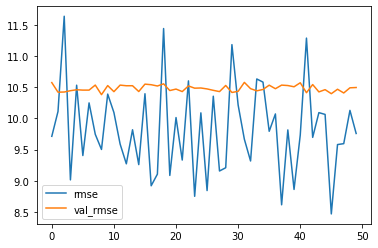

In [31]:
RMSE_COLS = ["rmse", "val_rmse"]

pd.DataFrame(history.history)[RMSE_COLS].plot()

<AxesSubplot:>

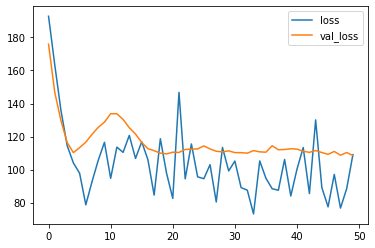

In [40]:
LOSS_COLS = ["loss", "val_loss"]

pd.DataFrame(history.history)[LOSS_COLS].plot()

# Making predictions with our model

To make predictions with our trained model, we can call the [predict method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict), passing to it a dictionary of values. The `steps` parameter determines the total number of steps before declaring the prediction round finished. Here since we have just one example, we set `steps=1` (setting `steps=None` would also work). Note, however, that if x is a `tf.data` dataset or a dataset iterator, and steps is set to None, predict will run until the input dataset is exhausted.

In [32]:
model.predict(
    x={
        "pickup_longitude": tf.convert_to_tensor([-73.982683]),
        "pickup_latitude": tf.convert_to_tensor([40.742104]),
        "dropoff_longitude": tf.convert_to_tensor([-73.983766]),
        "dropoff_latitude": tf.convert_to_tensor([40.755174]),
        "passenger_count": tf.convert_to_tensor([3.0]),
    },
    steps=1,
)

1/1 [==============================] - 0s 265ms/step


array([[11.513676]], dtype=float32)

# Export and deploy our model

Of course, making individual predictions is not realistic, because we can't expect client code to have a model object in memory. For others to use our trained model, we'll have to export our model to a file, and expect client code to instantiate the model from that exported file. 

We'll export the model to a TensorFlow SavedModel format. Once we have a model in this format, we have lots of ways to "serve" the model, from a web application, from JavaScript, from mobile applications, etc.

In [33]:
OUTPUT_DIR = "./export/savedmodel"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

EXPORT_PATH = os.path.join(OUTPUT_DIR, TIMESTAMP)

tf.saved_model.save(model, EXPORT_PATH)  # with default serving function

INFO:tensorflow:Assets written to: ./export/savedmodel/20240726172253/assets


INFO:tensorflow:Assets written to: ./export/savedmodel/20240726172253/assets


In [34]:
!saved_model_cli show \
    --tag_set serve \
    --signature_def serving_default \
    --dir {EXPORT_PATH}

!find {EXPORT_PATH}
os.environ['EXPORT_PATH'] = EXPORT_PATH

2024-07-26 17:23:00.908005: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
The given SavedModel SignatureDef contains the following input(s):
  inputs['dropoff_latitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dropoff_latitude:0
  inputs['dropoff_longitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dropoff_longitude:0
  inputs['passenger_count'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_passenger_count:0
  inputs['pickup_latitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_pickup_latitude:0
  inputs['pickup_longitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_defau

## Deploy our model to Vertex AI

Finally, we will deploy our trained model to Vertex AI and see how we can make online predicitons. 

In [35]:
PROJECT = !gcloud config list --format 'value(core.project)' 2>/dev/null
PROJECT = PROJECT[0]
BUCKET = PROJECT
REGION = "us-central1"
MODEL_DISPLAYNAME = f"taxifare-kerase-sequential{TIMESTAMP}"

print(f"MODEL_DISPLAYNAME: {MODEL_DISPLAYNAME}")

# from https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers
SERVING_CONTAINER_IMAGE_URI = (
    "us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest"
)

os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION

IndexError: list index out of range

In [45]:
%%bash
# Create GCS bucket if it doesn't exist already...
exists=$(gsutil ls -d | grep -w gs://${BUCKET}/)

if [ -n "$exists" ]; then
    echo -e "Bucket exists, let's not recreate it."
else
    echo "Creating a new GCS bucket."
    gsutil mb -l ${REGION} gs://${BUCKET}
    echo "Here are your current buckets:"
    gsutil ls
fi

Bucket exists, let's not recreate it.


In [46]:
!gsutil cp -R $EXPORT_PATH gs://$BUCKET/$MODEL_DISPLAYNAME

Copying file://./export/savedmodel/20220227235931/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://./export/savedmodel/20220227235931/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://./export/savedmodel/20220227235931/variables/variables.index [Content-Type=application/octet-stream]...
/ [3 files][205.3 KiB/205.3 KiB]                                                
Operation completed over 3 objects/205.3 KiB.                                    


In [47]:
uploaded_model = aiplatform.Model.upload(
    display_name=MODEL_DISPLAYNAME,
    artifact_uri=f"gs://{BUCKET}/{MODEL_DISPLAYNAME}",
    serving_container_image_uri=SERVING_CONTAINER_IMAGE_URI,
)

INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/333736501253/locations/us-central1/models/716885979356463104/operations/5773091973229445120
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/333736501253/locations/us-central1/models/716885979356463104
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/333736501253/locations/us-central1/models/716885979356463104')


In [48]:
MACHINE_TYPE = "e2-standard-2"

endpoint = uploaded_model.deploy(
    machine_type=MACHINE_TYPE,
    accelerator_type=None,
    accelerator_count=None,
)

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/333736501253/locations/us-central1/endpoints/8266682571480367104/operations/7317826645417525248
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/333736501253/locations/us-central1/endpoints/8266682571480367104
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/333736501253/locations/us-central1/endpoints/8266682571480367104')
INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/333736501253/locations/us-central1/endpoints/8266682571480367104
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/333736501253/locations/us-central1/endpoints/8266682571480367104/operations/8110460179834732544
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/33373650125

In [54]:
instance = {
    "pickup_longitude": -73.982683,
    "pickup_latitude": 40.742104,
    "dropoff_longitude": -73.983766,
    "dropoff_latitude": 40.755174,
    "passenger_count": 3.0,
}

In [55]:
endpoint.predict([instance])

Prediction(predictions=[[12.0436659]], deployed_model_id='1669595212638322688', explanations=None)

# Cleanup

When deploying a model to an endpoint for online prediction, the minimum `min-replica-count` is 1, and it is charged per node hour. So let's delete the endpoint to reduce unnecessary charges. Before we can delete the endpoint, we first undeploy all attached models... 

In [26]:
endpoint.undeploy_all()

INFO:google.cloud.aiplatform.models:Undeploying Endpoint model: projects/333736501253/locations/us-central1/endpoints/1809646605737918464
INFO:google.cloud.aiplatform.models:Undeploy Endpoint model backing LRO: projects/333736501253/locations/us-central1/endpoints/1809646605737918464/operations/1963046688474005504
INFO:google.cloud.aiplatform.models:Endpoint model undeployed. Resource name: projects/333736501253/locations/us-central1/endpoints/1809646605737918464


resource name: projects/333736501253/locations/us-central1/endpoints/1809646605737918464

...then delete the endpoint.

In [27]:
endpoint.delete()

INFO:google.cloud.aiplatform.base:Deleting Endpoint : projects/333736501253/locations/us-central1/endpoints/1809646605737918464
INFO:google.cloud.aiplatform.base:Delete Endpoint  backing LRO: projects/333736501253/locations/us-central1/operations/1264988746231578624
INFO:google.cloud.aiplatform.base:Endpoint deleted. . Resource name: projects/333736501253/locations/us-central1/endpoints/1809646605737918464


Copyright 2021 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License